In [2]:
import geopandas as gpd
import xarray as xr
import rioxarray 
from shapely.geometry import box
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from geocube.api.core import make_geocube



root = Path.cwd()


class Site():
    def __init__(self,site_name,sentinel_data,polygons):
        self.site_name = site_name
        self.sentinel_data = sentinel_data.rio.write_crs(26918).rio.set_spatial_dims(x_dim="x",y_dim="y",).rio.write_coordinate_system()
        self.polygons = polygons.reset_index().to_crs(26918)
        self.bbox = self.get_bbox()

        self.site_polygons = self.get_site_polygons()

        self.beech_idx = self.site_polygons.loc[self.site_polygons.Name!='non-beech stand']['index'].astype('float').values
        self.nonbeech_idx = self.site_polygons.loc[self.site_polygons.Name=='non-beech stand']['index'].astype('float').values

        self.raster_polys = self.rasterize_polys()

    def get_bbox(self):
        b = self.sentinel_data.rio.bounds()
        return box(*b)
    
    def get_site_polygons(self):
        df = gpd.GeoDataFrame({"id":1,"geometry":[self.bbox]})
        idx = df.sindex.query(self.polygons.geometry, predicate="intersects")[0]
        return self.polygons.iloc[idx]
    
    # rasterize polygons
    def rasterize_polys(self):
        g = make_geocube(
        vector_data=self.site_polygons,
        measurements=["index"],
        like=self.sentinel_data, # ensure the data are on the same grid
    )
        return g
    
    # plot rasterized polygons overlaid with vector polygons
    def plot_rasterized_polys(self):
        fig, ax = plt.subplots(ncols=1, figsize=(5, 5))

        p = self.raster_polys.index.plot.imshow(ax=ax)
        self.site_polygons.plot(ax=ax,alpha=.7)
        p.colorbar.remove()
        plt.title(f'Rasterized Polygons: {self.site_name.title()} Site')
        plt.tight_layout()
        plt.show()

    # store pixel values for each plot in dataframe
    def make_pixel_df(self,idx='beech'):
        
        if idx == 'beech':
            id = self.beech_idx
        else:
            id = self.nonbeech_idx

        if len(id) == 1:
            pixels = self.sentinel_data.where(self.raster_polys.index==id).assign_coords({'time':[str(x.astype('datetime64[D]')) for x in self.sentinel_data.time.values]})
        else:
            pixels = self.sentinel_data.where((self.raster_polys.index==id[0])|(self.raster_polys.index==id[1]))

        stacked = pixels.stack(spatial=('x','y'))
        transposed = stacked.transpose('spatial', 'band', 'time')
        # convert to dataframe
        df = transposed.to_dataframe(name='value').unstack(['band', 'time'])

        df = df.loc[:,('value')]

        df.columns = df.columns.set_levels([str(x.astype('datetime64[D]')) for x in self.sentinel_data.time.values],level='time')
        df = df.reset_index()

        df.columns = [f'{x[0]}_{x[1]}' for x in df.columns]

        df.rename(columns={df.columns[0]:'x',df.columns[1]:'y'},inplace=True)

        df = df.drop(['x','y'],axis=1)

        df = df[df.isna().sum(axis=1) == 0]
        print(df.shape)

        return df
        

    
    # store mean values for each plot in dataframe
    def make_site_means_df(self, i='beech'):

        out_grid = self.raster_polys
    
        out_grid['sentinel'] = (self.sentinel_data.dims, self.sentinel_data.values, self.sentinel_data.attrs, self.sentinel_data.encoding)

        # calculate means for each group (polygon)
        grouped_sentinel = out_grid.drop_vars("spatial_ref").groupby(out_grid.index)
        grid_mean = grouped_sentinel.mean().rename({"sentinel": "sentinel_mean"})

        zonal_stats = grid_mean.to_dataframe()

        # put beech/nonbeech into seperate dataframes 
        if i == 'beech':
            idx = self.beech_idx
        else:
            idx = self.nonbeech_idx
        
        df = zonal_stats.loc[idx]
        
        df_unstack = df.unstack(level='band').droplevel('band',axis=1)
        df_unstack.columns = self.sentinel_data.band.values

        if len(np.unique(df_unstack.index.get_level_values(level='index'))) < 2: # check if multiple polygons
            df_unstack = df_unstack.reset_index()
            df_unstack['time'] = [str(x.astype('datetime64[D]')) for x in self.sentinel_data.time.values]
            return df_unstack
        
        else:   # if multiple polygons, return a list of dataframes
            df_list = []
            for i in range(0,len(idx)):
                df1 = df_unstack.loc[idx[i]]
                df1 = df1.reset_index()
                df1['time'] = [str(x.astype('datetime64[D]')) for x in self.sentinel_data.time.values]
                df_list.append(df1)
            
            return df_list


In [103]:
polys = gpd.read_file(root / 'beech_stands' / 'Beech Stand Polygons.kml')
#polys = polys.reset_index().to_crs(26918)

In [104]:
SITE = 'pecoy'

sentinel = xr.open_dataarray(root / 'sentinel_data' / f'2023_{SITE}.nc')
# set crs and spatial dims
#sentinel = sentinel.rio.write_crs(26918).rio.set_spatial_dims(x_dim="x",y_dim="y",).rio.write_coordinate_system()

In [132]:
pecoy = Site('Pecoy',sentinel, polys)

In [ ]:
roundtop = Site('Roundtop',sentinel)

In [ ]:
beech_pixels = pd.concat([pecoy.make_pixel_df('beech')])

(12, 290)


,B02_2023-01-15,B02_2023-02-04,B02_2023-02-11,B02_2023-02-14,B02_2023-03-16,B02_2023-03-21,B02_2023-03-26,B02_2023-04-02,B02_2023-04-12,B02_2023-05-10,...,B12_2023-09-14,B12_2023-09-27,B12_2023-10-04,B12_2023-10-12,B12_2023-10-27,B12_2023-11-03,B12_2023-11-16,B12_2023-11-18,B12_2023-12-13,B12_2023-12-21
116,0.0960,0.1464,0.0364,0.0260,0.2930,0.1378,0.2038,0.0607,0.0467,0.0553,...,0.0837,0.0703,0.0885,0.0906,0.1057,0.1145,0.1002,0.1023,0.0726,0.0844
137,0.1066,0.1836,0.0384,0.0309,0.2768,0.2128,0.2170,0.0706,0.0494,0.0566,...,0.0837,0.0703,0.0885,0.0906,0.1057,0.1145,0.1002,0.1023,0.0726,0.0844
138,0.1086,0.1724,0.0394,0.0279,0.2546,0.2602,0.2136,0.0412,0.0486,0.0564,...,0.0837,0.0703,0.0885,0.0906,0.1057,0.1145,0.1002,0.1023,0.0726,0.0844
158,0.0715,0.1146,0.0374,0.0236,0.1842,0.1642,0.2270,0.0505,0.0434,0.0554,...,0.0825,0.0668,0.0864,0.0884,0.1075,0.1129,0.1030,0.1031,0.0732,0.0867
159,0.0816,0.1124,0.0399,0.0231,0.1908,0.2368,0.2270,0.0406,0.0448,0.0560,...,0.0825,0.0668,0.0864,0.0884,0.1075,0.1129,0.1030,0.1031,0.0732,0.0867
179,0.1019,0.1544,0.0376,0.0276,0.2290,0.1884,0.1726,0.0356,0.0426,0.0536,...,0.0825,0.0668,0.0864,0.0884,0.1075,0.1129,0.1030,0.1031,0.0732,0.0867
180,0.0902,0.1304,0.0378,0.0301,0.2072,0.1630,0.1212,0.0307,0.0452,0.0531,...,0.0825,0.0668,0.0864,0.0884,0.1075,0.1129,0.1030,0.1031,0.0732,0.0867
368,0.1314,0.1914,0.0378,0.0326,0.3216,0.3132,0.2614,0.0677,0.0527,0.0556,...,0.0712,0.0591,0.0747,0.0819,0.1144,0.1299,0.1214,0.1180,0.0678,0.1010
369,0.1246,0.1836,0.0392,0.0304,0.2746,0.3044,0.2250,0.0642,0.0492,0.0528,...,0.0712,0.0591,0.0747,0.0819,0.1144,0.1299,0.1214,0.1180,0.0678,0.1010
370,0.1280,0.1760,0.0378,0.0300,0.2776,0.2696,0.2186,0.0413,0.0472,0.0524,...,0.0716,0.0605,0.0758,0.0842,0.1231,0.1366,0.1240,0.1214,0.0698,0.1023


In [77]:
# create bounding box polygon of sentinel array
bounds = sentinel.rio.bounds()
sentinel_bbox = box(*bounds)

# get the polygons that intersect with the bounding box
df = gpd.GeoDataFrame({"id":1,"geometry":[sentinel_bbox]})
idx = df.sindex.query(polys.geometry, predicate="intersects")[0]
polys_selected = polys.iloc[idx]
polys_selected.shape

# get index numbers for beech/nonbeech polygons
beech_idx = polys_selected.loc[polys_selected.Name!='non-beech stand']['index'].astype('float').values
nonbeech_idx = polys_selected.loc[polys_selected.Name=='non-beech stand']['index'].astype('float').values

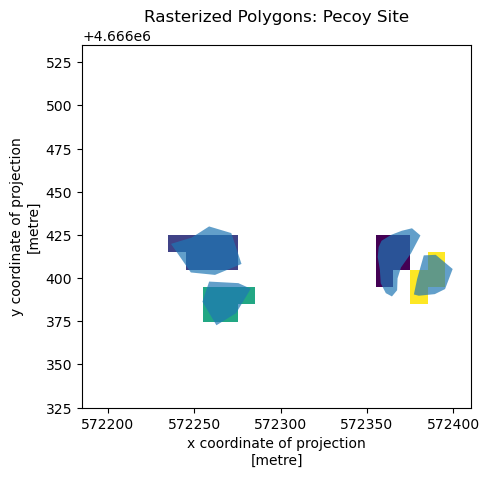

In [79]:
# rasterize polygons
out_grid = make_geocube(
    vector_data=polys_selected,
    measurements=["index"],
    like=sentinel, # ensure the data are on the same grid
)


 # plot rasterized polygons overlaid with vector polygons
fig, ax = plt.subplots(ncols=1, figsize=(5, 5))

p = out_grid.index.plot.imshow(ax=ax)
polys_selected.plot(ax=ax,alpha=.7)
p.colorbar.remove()
plt.title(f'Rasterized Polygons: {SITE.title()} Site')
plt.tight_layout()
plt.show()

In [101]:
pixels = sentinel.where((out_grid.index==beech_idx[0])|(out_grid.index==beech_idx[1]))
#.assign_coords({'time':[str(x.astype('datetime64[D]')) for x in sentinel.time.values]})

In [98]:
beech_idx.reshape(1,2)

array([[1., 2.]])

In [94]:
out_grid

<xarray.Dataset> Size: 4kB
Dimensions:      (y: 21, x: 21)
Coordinates:
  * y            (y) float64 168B 4.667e+06 4.667e+06 ... 4.666e+06 4.666e+06
  * x            (x) float64 168B 5.722e+05 5.722e+05 ... 5.724e+05 5.724e+05
    spatial_ref  int64 8B 0
Data variables:
    index        (y, x) float64 4kB nan nan nan nan nan ... nan nan nan nan nan

In [129]:
df.columns = df.columns.set_levels([str(x.astype('datetime64[D]')) for x in sentinel.time.values],level='time')

In [130]:
df

band                      B02                                              \
time               2023-01-15 2023-02-04 2023-02-11 2023-02-14 2023-03-16   
x        y                                                                  
572190.0 4666530.0        NaN        NaN        NaN        NaN        NaN   
         4666520.0        NaN        NaN        NaN        NaN        NaN   
         4666510.0        NaN        NaN        NaN        NaN        NaN   
         4666500.0        NaN        NaN        NaN        NaN        NaN   
         4666490.0        NaN        NaN        NaN        NaN        NaN   
...                       ...        ...        ...        ...        ...   
572390.0 4666370.0        NaN        NaN        NaN        NaN        NaN   
         4666360.0        NaN        NaN        NaN        NaN        NaN   
         4666350.0        NaN        NaN        NaN        NaN        NaN   
         4666340.0        NaN        NaN        NaN        NaN        NaN   
         4666330.0        NaN        NaN        NaN        NaN        NaN   

band                                                                       \
time               2023-03-21 2023-03-26 2023-04-02 2023-04-12 2023-05-10   
x        y                                                                  
572190.0 4666530.0        NaN        NaN        NaN        NaN        NaN   
         4666520.0        NaN        NaN        NaN        NaN        NaN   
         4666510.0        NaN        NaN        NaN        NaN        NaN   
         4666500.0        NaN        NaN        NaN        NaN        NaN   
         4666490.0        NaN        NaN        NaN        NaN        NaN   
...                       ...        ...        ...        ...        ...   
572390.0 4666370.0        NaN        NaN        NaN        NaN        NaN   
         4666360.0        NaN        NaN        NaN        NaN        NaN   
         4666350.0        NaN        NaN        NaN        NaN        NaN   
         4666340.0        NaN        NaN        NaN        NaN        NaN   
         4666330.0        NaN        NaN        NaN        NaN        NaN   

band                ...        B12                                   \
time                ... 2023-09-14 2023-09-27 2023-10-04 2023-10-12   
x        y          ...                                               
572190.0 4666530.0  ...        NaN        NaN        NaN        NaN   
         4666520.0  ...        NaN        NaN        NaN        NaN   
         4666510.0  ...        NaN        NaN        NaN        NaN   
         4666500.0  ...        NaN        NaN        NaN        NaN   
         4666490.0  ...        NaN        NaN        NaN        NaN   
...                 ...        ...        ...        ...        ...   
572390.0 4666370.0  ...        NaN        NaN        NaN        NaN   
         4666360.0  ...        NaN        NaN        NaN        NaN   
         4666350.0  ...        NaN        NaN        NaN        NaN   
         4666340.0  ...        NaN        NaN        NaN        NaN   
         4666330.0  ...        NaN        NaN        NaN        NaN   

band                                                                       \
time               2023-10-27 2023-11-03 2023-11-16 2023-11-18 2023-12-13   
x        y                                                                  
572190.0 4666530.0        NaN        NaN        NaN        NaN        NaN   
         4666520.0        NaN        NaN        NaN        NaN        NaN   
         4666510.0        NaN        NaN        NaN        NaN        NaN   
         4666500.0        NaN        NaN        NaN        NaN        NaN   
         4666490.0        NaN        NaN        NaN        NaN        NaN   
...                       ...        ...        ...        ...        ...   
572390.0 4666370.0        NaN        NaN        NaN        NaN        NaN   
         4666360.0        NaN        NaN        NaN        NaN        NaN   


In [119]:


# stacked = pixels.stack(spatial=('x','y'))
# transposed = stacked.transpose('spatial', 'band', 'time')
# # convert to dataframe
# df = transposed.to_dataframe(name='value').unstack(['band', 'time'])

# df = df.loc[:,('value')]

df['time'] = [str(x.astype('datetime64[D]')) for x in sentinel.time.values]
#df = df.reset_index()
df
# df.columns = [f'{x[0]}_{x[1]}' for x in df.columns]

# df.rename(columns={df.columns[0]:'x',df.columns[1]:'y'},inplace=True)

# df = df.drop(['x','y'],axis=1)

# df = df[df.isna().sum(axis=1) == 0]
# print(df.shape)

ValueError: Length of values (29) does not match length of index (441)

In [60]:
def make_pixel_df(s,rast_polys,idx):

    pixels = s.where(rast_polys.index==idx).assign_coords({'time':[str(x.astype('datetime64[D]')) for x in s.time.values]})

    stacked = pixels.stack(spatial=('x','y'))
    transposed = stacked.transpose('spatial', 'band', 'time')
    # convert to dataframe
    df = transposed.to_dataframe(name='value').unstack(['band', 'time'])

    df = df.loc[:,('value')]
    df = df.reset_index()

    df.columns = [f'{x[0]}_{x[1]}' for x in df.columns]

    df.rename(columns={df.columns[0]:'x',df.columns[1]:'y'},inplace=True)

    df = df.drop(['x','y'],axis=1)

    df = df[df.isna().sum(axis=1) == 0]
    print(df.shape)

    return df

### Get mean values for plots

In [7]:
# add satellite data to dataset
out_grid['sentinel'] = (sentinel.dims, sentinel.values, sentinel.attrs, sentinel.encoding)

# calculate means for each group (polygon)
grouped_sentinel = out_grid.drop_vars("spatial_ref").groupby(out_grid.index)
grid_mean = grouped_sentinel.mean().rename({"sentinel": "sentinel_mean"})

c:\Users\roseh\miniconda3\envs\beech-env\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension index because variable index is not a coordinate. To create an index for index, please first call `.set_coords('index')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


In [8]:
zonal_stats = grid_mean.to_dataframe()

# put beech/nonbeech into seperate dataframes 
beech_means = zonal_stats.loc[beech_idx]
nonbeech_means = zonal_stats.loc[nonbeech_idx]

In [ ]:
def make_site_means_dfs(self, i='beech'):

    out_grid = self.raster_polys
   
    out_grid['sentinel'] = (self.sentinel_data.dims, self.sentinel_data.values, self.sentinel_data.attrs, self.sentinel_data.encoding)

    # calculate means for each group (polygon)
    grouped_sentinel = out_grid.drop_vars("spatial_ref").groupby(out_grid.index)
    grid_mean = grouped_sentinel.mean().rename({"sentinel": "sentinel_mean"})

    zonal_stats = grid_mean.to_dataframe()

    # put beech/nonbeech into seperate dataframes 
    if i == 'beech':
        df = zonal_stats.loc[self.beech_idx]
    else:
        df = zonal_stats.loc[self.nonbeech_idx]
    
    df_unstack = df.unstack(level='band').droplevel('band',axis=1)
    df_unstack.columns = self.sentinel_data.band.values

    if len(np.unique(df_unstack.index.get_level_values(level='index'))) < 2: # check if multiple polygons
        df_unstack = df_unstack.reset_index()
        df_unstack['time'] = [str(x.astype('datetime64[D]')) for x in self.sentinel_data.time.values]
        return df_unstack
    
    else:   # if multiple polygons, return a list of dataframes
        df_list = []
        for i in range(0,len(idx)):
            df1 = df_unstack.loc[idx[i]]
            df1 = df1.reset_index()
            df1['time'] = [str(x.astype('datetime64[D]')) for x in self.sentinel_data.time.values]
            df_list.append(df1)
        
        return df_list

In [9]:
def unstack_and_relabel_dfs(df,idx=None):
    """Reformat and tidy dataframes produced by calling to_dataframe() on zonal stats array"""

    df_unstack = df.unstack(level='band').droplevel('band',axis=1)
    df_unstack.columns = sentinel.band.values

    if len(np.unique(df_unstack.index.get_level_values(level='index'))) < 2: # check if multiple polygons
        df_unstack = df_unstack.reset_index()
        df_unstack['time'] = [str(x.astype('datetime64[D]')) for x in sentinel.time.values]
        return df_unstack
    
    else:   # if multiple polygons, return a list of dataframes
        df_list = []
        for i in range(0,len(idx)):
            df1 = df_unstack.loc[idx[i]]
            df1 = df1.reset_index()
            df1['time'] = [str(x.astype('datetime64[D]')) for x in sentinel.time.values]
            df_list.append(df1)
        
        return df_list
        

        

In [10]:
# reformat and label dataframes
beech_means = unstack_and_relabel_dfs(beech_means)
nonbeech_means = unstack_and_relabel_dfs(nonbeech_means)

In [11]:
# save to disk
beech_means.to_csv(root / 'output' / f'{SITE}_beech_polygon_means.csv')
nonbeech_means.to_csv(root / 'output' / f'{SITE}_nonbeech_polygon_means.csv')